## MLP for Singapore Airlines Sentiment Analysis

In [3]:
import pandas as pd
import numpy as np
from scipy.sparse import load_npz
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt

### Data Loading

In [4]:
# Load features
X_train = load_npz("data/new_split/X_train_tfidf.npz")
X_val   = load_npz("data/new_split/X_val_tfidf.npz")
X_test  = load_npz("data/new_split/X_test_tfidf.npz")

# Load labels
y_train = pd.read_csv("data/new_split/train_split.csv")["label"].values
y_val   = pd.read_csv("data/new_split/val_split.csv")["label"].values
y_test  = pd.read_csv("data/new_split/test_split.csv")["label"].values

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (8165, 51593) (8165,)
Validation set shape: (1167, 51593) (1167,)
Test set shape: (2333, 51593) (2333,)


In [7]:
pd.DataFrame(y_train).value_counts()

0       
positive    5923
negative    1467
neutral      775
Name: count, dtype: int64

In [4]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)
y_test = le.transform(y_test)
label_names = list(le.classes_)
print("Classes:", label_names)

Classes: ['negative', 'neutral', 'positive']


Adjust Class Weights to address imbalance

In [5]:
class_counts = np.bincount(y_train, minlength=3)
class_weights = (class_counts.sum() / (len(class_counts) * np.maximum(class_counts, 1))).astype("float32")
class_weights = torch.tensor(class_weights)

In [6]:
class SparseCSRDataset(Dataset):
    def __init__(self, X_csr, y):
        self.X = X_csr
        self.y = y
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx].toarray().squeeze(0).astype("float32")
        y = np.int64(self.y[idx])
        return x, y
    
train_loader = DataLoader(SparseCSRDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(SparseCSRDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(SparseCSRDataset(X_test, y_test), batch_size=128, shuffle=False)

### Define MLP Model (2-Layer)

In [7]:
in_dim = X_train.shape[1]

class MLP(nn.Module):
    def __init__(self, in_dim=in_dim, out_dim=3, hidden=(512, 256), p=0.3):
        super().__init__()
        h1, h2 = hidden
        self.fc1 = nn.Linear(in_dim, h1, bias=True)
        self.bn1 = nn.BatchNorm1d(h1)
        self.fc2 = nn.Linear(h1, h2, bias=True)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop = nn.Dropout(p)
        self.fc3 = nn.Linear(h2, out_dim, bias=True)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.drop(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.drop(x)
        x = self.fc3(x)
        return x

### Model Training and Validation

In [8]:
def train_one_epoch(model, device, optimizer, criterion, train_loader):
    model.train()
    train_loss = 0.0
    for data, target in train_loader:
        data = data.to(device, non_blocking=True).float()
        target = target.to(device, non_blocking=True).long()

        optimizer.zero_grad(set_to_none=True)
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / max(len(train_loader), 1)
    return model, avg_train_loss

In [9]:
def evaluate(model, device, criterion, val_loader):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_y, all_p = [], []

    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device, non_blocking=True).float()
            target = target.to(device, non_blocking=True).long()

            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            pred = output.argmax(dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)

            all_y.append(target.cpu().numpy())
            all_p.append(pred.cpu().numpy())

    avg_val_loss = val_loss / max(len(val_loader), 1)

    y_true = np.concatenate(all_y)
    y_pred = np.concatenate(all_p)
    val_acc = 100.0 * correct / max(total, 1)
    val_macro_f1 = f1_score(y_true, y_pred, average="macro")
    return avg_val_loss, val_acc, val_macro_f1

### Select the best model using Macro-f1 score/Accuracy

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

In [13]:
best = {"f1_score": -1.0, "accuracy": 0, 
        "cfg": None, "state": None, 
        "train_losses": [], "val_losses": [], 
        "val_accuracies": [], "val_f1s": []}

# Hyperparameter grids
HIDDEN_GRIDS = [
    (256, 128),
    (512, 256),
]
DROPOUTS = [0.1, 0.3, 0.5]
LRS = [0.01, 0.1, 0.5]
WDS = [0.0, 1e-3]

EPOCHS = 10

for hidden in HIDDEN_GRIDS:
    for p in DROPOUTS:
        for lr in LRS:
            for wd in WDS:
                model = MLP(in_dim=in_dim, out_dim=3, hidden=hidden, p=p)
                model = model.to(device)
                opt = torch.optim.Adadelta(model.parameters(), lr=lr, weight_decay=wd)
                
                train_losses = []
                val_losses = []
                val_accuracies = []
                val_f1s = []
                for epoch in range(1, EPOCHS+1):
                    model, train_loss = train_one_epoch(model, device, opt, criterion, train_loader)
                    val_loss, val_acc, val_f1_score = evaluate(model, device, criterion, val_loader)
                    train_losses.append(train_loss)
                    val_losses.append(val_loss)
                    val_accuracies.append(val_acc)
                    val_f1s.append(val_f1_score)
                print(f"[grid] hidden={hidden}, dropout={p}, lr={lr}, wd={wd} -> val macro-F1={val_f1_score:.4f}, val acc={val_acc:.2f}%")
                # if val_f1_score > best["f1_score"]:
                if val_acc > best["accuracy"]:
                    best["f1_score"] = val_f1_score
                    best["accuracy"] = val_acc
                    best["cfg"] = {"hidden": hidden, "dropout": p, "lr": lr, "weight_decay": wd}
                    best["state"] = {k: v.cpu() for k, v in model.state_dict().items()}
                    best["train_losses"] = train_losses
                    best["val_losses"] = val_losses
                    best["val_accuracies"] = val_accuracies
                    best["val_f1s"] = val_f1s
print("\nBest validation macro-F1:", round(best["f1_score"], 4))
print("\nBest validation accuracy:", round(best["accuracy"], 2), "%")
print("\nBest config:", best["cfg"])

[grid] hidden=(256, 128), dropout=0.1, lr=0.01, wd=0.0 -> val macro-F1=0.6594, val acc=79.09%
[grid] hidden=(256, 128), dropout=0.1, lr=0.01, wd=0.001 -> val macro-F1=0.6565, val acc=79.43%
[grid] hidden=(256, 128), dropout=0.1, lr=0.1, wd=0.0 -> val macro-F1=0.6897, val acc=81.83%
[grid] hidden=(256, 128), dropout=0.1, lr=0.1, wd=0.001 -> val macro-F1=0.6728, val acc=81.32%
[grid] hidden=(256, 128), dropout=0.1, lr=0.5, wd=0.0 -> val macro-F1=0.6752, val acc=82.01%
[grid] hidden=(256, 128), dropout=0.1, lr=0.5, wd=0.001 -> val macro-F1=0.6978, val acc=84.23%
[grid] hidden=(256, 128), dropout=0.3, lr=0.01, wd=0.0 -> val macro-F1=0.6701, val acc=79.09%
[grid] hidden=(256, 128), dropout=0.3, lr=0.01, wd=0.001 -> val macro-F1=0.6674, val acc=78.41%
[grid] hidden=(256, 128), dropout=0.3, lr=0.1, wd=0.0 -> val macro-F1=0.6581, val acc=80.72%
[grid] hidden=(256, 128), dropout=0.3, lr=0.1, wd=0.001 -> val macro-F1=0.6755, val acc=81.32%
[grid] hidden=(256, 128), dropout=0.3, lr=0.5, wd=0.0 ->

In [14]:
# Print training and validation process of best model
for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}: Train Loss={best['train_losses'][epoch-1]:.4f}, Val Loss={best['val_losses'][epoch-1]:.4f}, Val Acc={best['val_accuracies'][epoch-1]:.2f}%, Val Macro-F1={best['val_f1s'][epoch-1]:.4f}")

Epoch 1: Train Loss=0.6933, Val Loss=1.0469, Val Acc=74.98%, Val Macro-F1=0.3934
Epoch 2: Train Loss=0.1132, Val Loss=0.8008, Val Acc=83.63%, Val Macro-F1=0.6844
Epoch 3: Train Loss=0.0108, Val Loss=0.8922, Val Acc=84.32%, Val Macro-F1=0.6788
Epoch 4: Train Loss=0.0040, Val Loss=0.9387, Val Acc=84.06%, Val Macro-F1=0.6777
Epoch 5: Train Loss=0.0022, Val Loss=0.9630, Val Acc=84.58%, Val Macro-F1=0.6798
Epoch 6: Train Loss=0.0026, Val Loss=0.9623, Val Acc=84.66%, Val Macro-F1=0.6885
Epoch 7: Train Loss=0.0018, Val Loss=0.9694, Val Acc=84.49%, Val Macro-F1=0.6828
Epoch 8: Train Loss=0.0013, Val Loss=0.9445, Val Acc=84.15%, Val Macro-F1=0.6833
Epoch 9: Train Loss=0.0019, Val Loss=0.9406, Val Acc=84.58%, Val Macro-F1=0.6857
Epoch 10: Train Loss=0.0022, Val Loss=1.0245, Val Acc=84.49%, Val Macro-F1=0.6774


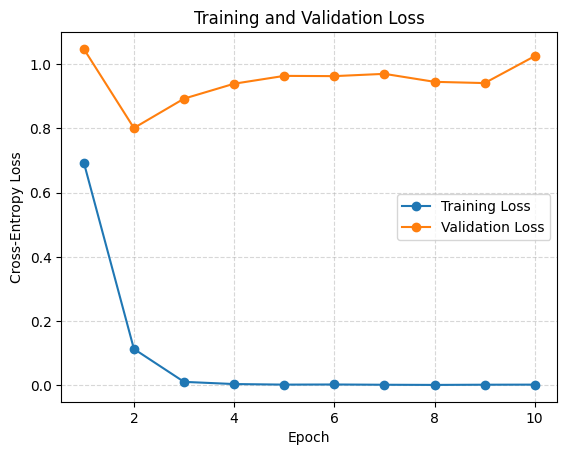

In [15]:
# Plot training and validation loss curves
plt.plot(range(1, EPOCHS+1), best["train_losses"], label='Training Loss', marker="o")
plt.plot(range(1, EPOCHS+1), best["val_losses"],   label='Validation Loss', marker="o")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Cross-Entropy Loss')
plt.legend(); plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### Evaluate Final Best Model

In [16]:
best_model = MLP(in_dim=in_dim, out_dim=3, hidden=best["cfg"]["hidden"], p=best["cfg"]["dropout"])
best_model.load_state_dict(best["state"])

for param_tensor in best_model.state_dict():
  print(param_tensor, ":", model.state_dict()[param_tensor].size())

fc1.weight : torch.Size([512, 51593])
fc1.bias : torch.Size([512])
bn1.weight : torch.Size([512])
bn1.bias : torch.Size([512])
bn1.running_mean : torch.Size([512])
bn1.running_var : torch.Size([512])
bn1.num_batches_tracked : torch.Size([])
fc2.weight : torch.Size([256, 512])
fc2.bias : torch.Size([256])
bn2.weight : torch.Size([256])
bn2.bias : torch.Size([256])
bn2.running_mean : torch.Size([256])
bn2.running_var : torch.Size([256])
bn2.num_batches_tracked : torch.Size([])
fc3.weight : torch.Size([3, 256])
fc3.bias : torch.Size([3])


In [ ]:
# Save best model
# torch.save(best_model.state_dict(), "mlp_model.pth")

In [18]:
def loader_preds(model, loader, device):
    model.eval()
    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device).float()
            yb = yb.to(device).long()
            pred = model(xb).argmax(1)
            ys.append(yb.cpu().numpy())
            ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    return y_true, y_pred

### Test Report

In [34]:
y_test_true, y_test_pred = loader_preds(best_model, test_loader, device)
test_acc = accuracy_score(y_test_true, y_test_pred)
test_macro_f1 = f1_score(y_test_true, y_test_pred, average="macro")
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"\nTest Macro-F1: {test_macro_f1:.4f}")
print("\nTest classification report:")
print(classification_report(y_test_true, y_test_pred, target_names=label_names, digits=4))


Test Accuracy: 0.8534

Test Macro-F1: 0.6901

Test classification report:
              precision    recall  f1-score   support

    negative     0.6896    0.8377    0.7565       419
     neutral     0.4479    0.3288    0.3792       222
    positive     0.9434    0.9261    0.9347      1692

    accuracy                         0.8534      2333
   macro avg     0.6936    0.6976    0.6901      2333
weighted avg     0.8507    0.8534    0.8498      2333



### Performance Analysis

In [27]:
labels = list(label_names)
cm = confusion_matrix(y_test_true, y_test_pred, labels=np.arange(len(labels)))

cm_df = pd.DataFrame(
    cm,
    index=[f"true_{lbl}" for lbl in labels],
    columns=[f"pred_{lbl}" for lbl in labels]
)
print("\nConfusion Matrix (counts):")
print(cm_df)


Confusion Matrix (counts):
               pred_negative  pred_neutral  pred_positive
true_negative            351            41             27
true_neutral              82            73             67
true_positive             76            49           1567


In [ ]:
test_df = pd.read_csv("data/new_split/test_split.csv")

# create dataframe with predictions and filter misclassified examples
df_preds = test_df.copy()
df_preds['predicted_label'] = le.inverse_transform(y_test_pred)
df_preds['predicted_encoded'] = y_test_pred
df_preds['true_encoded'] = y_test_true

misclassified_df = df_preds[df_preds['label'] != df_preds['predicted_label']].reset_index(drop=True)

display(misclassified_df.head())
print(f"Misclassified count: {len(misclassified_df)}")

,index,text,label,predicted_label,predicted_encoded,true_encoded
0,11071,Perth to Zurich return via Singapore. I booked...,negative,neutral,1,0
1,9856,Over all flying with. Singapore Airlines is a ...,neutral,positive,2,1
2,10557,Munich to Singapore. Unfortunately SQ uses LH ...,positive,negative,0,2
3,3722,Tech great Passenger comfort not. We looked fo...,neutral,positive,2,1
4,1521,I had an abusive drunk behind me and should no...,neutral,negative,0,1


Misclassified count: 342


Performance summary:
- Per-class Performance:
    - Positive: Very strong — precision 94.3%, recall 92.6% (most positive reviews are correctly found, with few false positives).
    - Negative: Recall 83.8% is high, but precision 68.9% is moderate — about 31% of predicted negatives are actually neutral/positive (over-calling “Negative”).
    - Neutral: The weakest class — precision 44.8%, recall 32.9%, F1 0.379 — indicating difficulty identifying genuinely neutral reviews.

- True Neutral misclassified:
    - as Negative: 82/222 (36.9%)
    - as Positive: 67/222 (30.2%)
    - These errors are fairly balanced in both directions, consistent with the ambiguity of many 3-star reviews: the text often mixes mild pros and cons, so it can lean either way.